In [36]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('lane_pub_log.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)
data.columns

Index(['theta', 'b', 'detected'], dtype='object')

In [37]:
class MovingAverageLPF:
    def __init__(self, window_size):
        self.window_size = window_size
        self.buffer = []
    
    def update(self, new_value):
        self.buffer.append(new_value)
        
        if len(self.buffer) > self.window_size:
            self.buffer.pop(0)
        
        if len(self.buffer) == self.window_size:
            return sum(self.buffer) / self.window_size
        else:
            return new_value  # or return None if you prefer to wait

# Example usage with the existing data
n = 30
theta_filter = MovingAverageLPF(n)
b_filter = MovingAverageLPF(n)

# Create a new dataframe for real-time filtered data
data_realtime = pd.DataFrame(index=data.index)
data_realtime['theta_realtime_lpf'] = None
data_realtime['b_realtime_lpf'] = None

for i, (timestamp, row) in enumerate(data.iterrows()):
    theta_filtered = theta_filter.update(row['theta'])
    b_filtered = b_filter.update(row['b'])
    
    data_realtime.loc[timestamp, 'theta_realtime_lpf'] = theta_filtered
    data_realtime.loc[timestamp, 'b_realtime_lpf'] = b_filtered

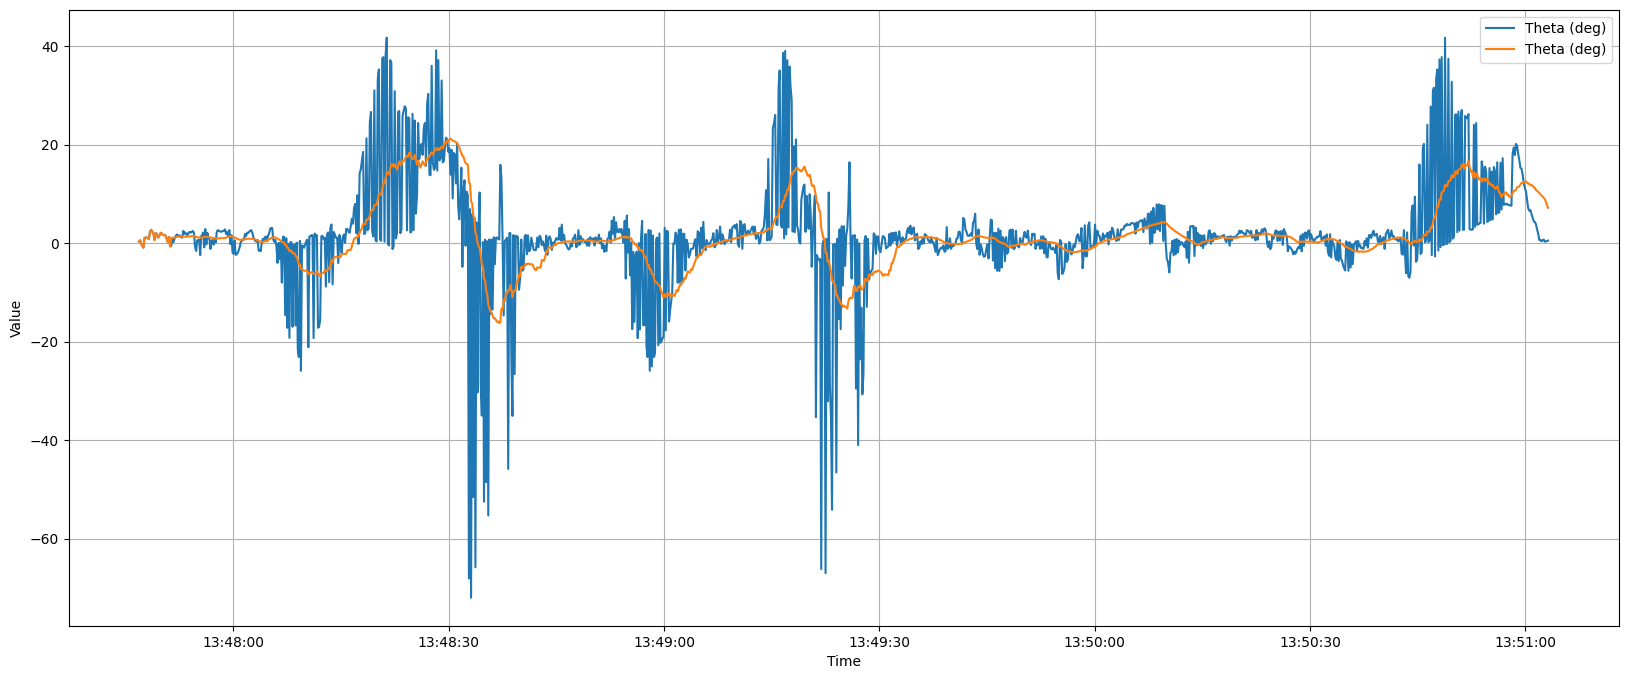

In [38]:
plt.figure(figsize=(20,8))

plt.plot(data.index, data['theta'], label='Theta (deg)')
plt.plot(data_realtime.index, data_realtime['theta_realtime_lpf'], label='Theta (deg)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()

plt.show()

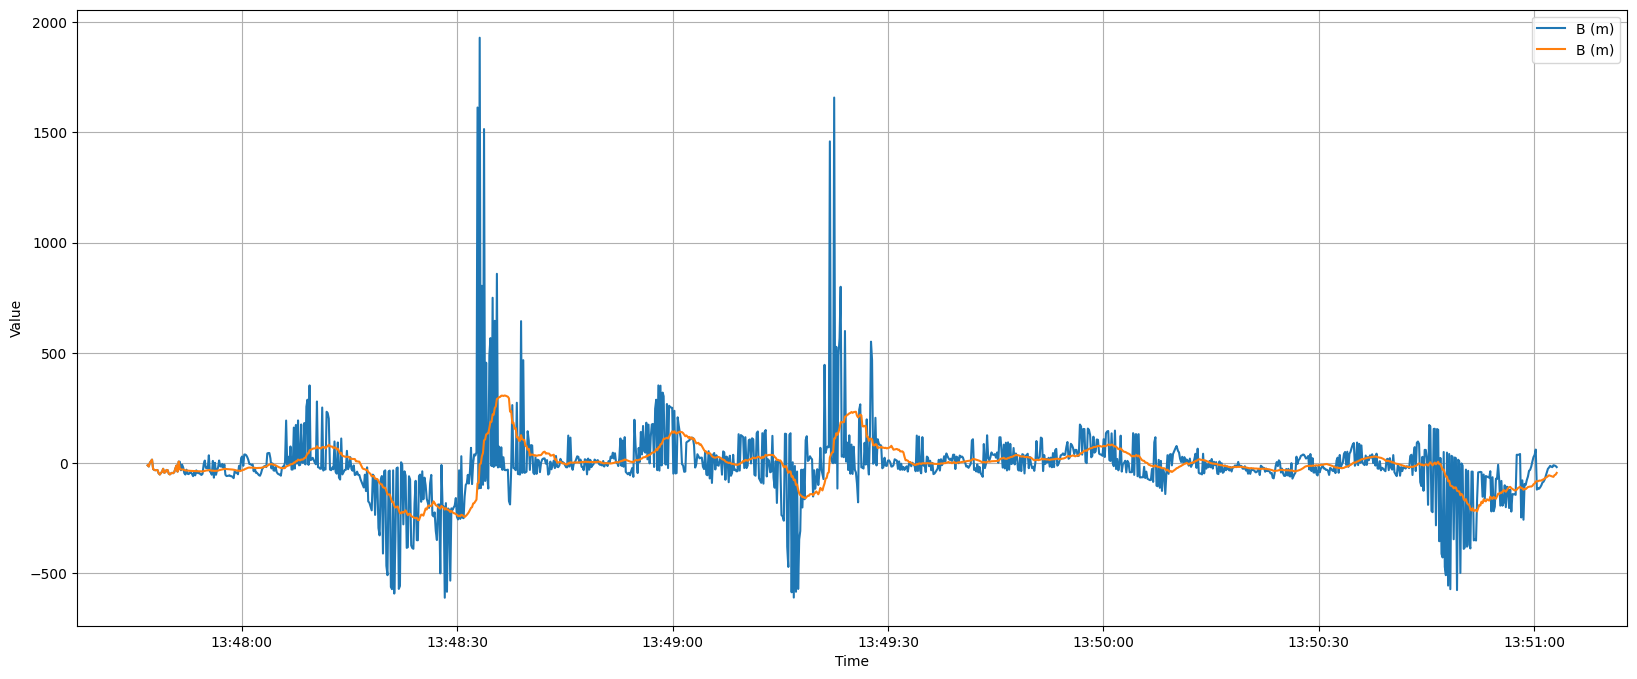

In [39]:
plt.figure(figsize=(20,8))

plt.plot(data.index, data['b'], label='B (m)')
plt.plot(data_realtime.index, data_realtime['b_realtime_lpf'], label='B (m)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid()

plt.show()

In [43]:
class ExponentialMovingAverageLPF:
    def __init__(self, alpha):
        self.alpha = alpha
        self.ema = None
    
    def update(self, new_value):
        if self.ema is None:
            self.ema = new_value
        else:
            self.ema = self.alpha * new_value + (1 - self.alpha) * self.ema
        return self.ema

# Example usage with the existing data
alpha = 0.05  # smoothing factor (0 < alpha <= 1)
theta_ema_filter = ExponentialMovingAverageLPF(alpha)
b_ema_filter = ExponentialMovingAverageLPF(alpha)

# Add EMA columns to existing dataframe
data_realtime['theta_ema_lpf'] = None
data_realtime['b_ema_lpf'] = None

# Reset filters and process data again
theta_ema_filter = ExponentialMovingAverageLPF(alpha)
b_ema_filter = ExponentialMovingAverageLPF(alpha)

for timestamp, row in data.iterrows():
    theta_ema = theta_ema_filter.update(row['theta'])
    b_ema = b_ema_filter.update(row['b'])
    
    data_realtime.loc[timestamp, 'theta_ema_lpf'] = theta_ema
    data_realtime.loc[timestamp, 'b_ema_lpf'] = b_ema

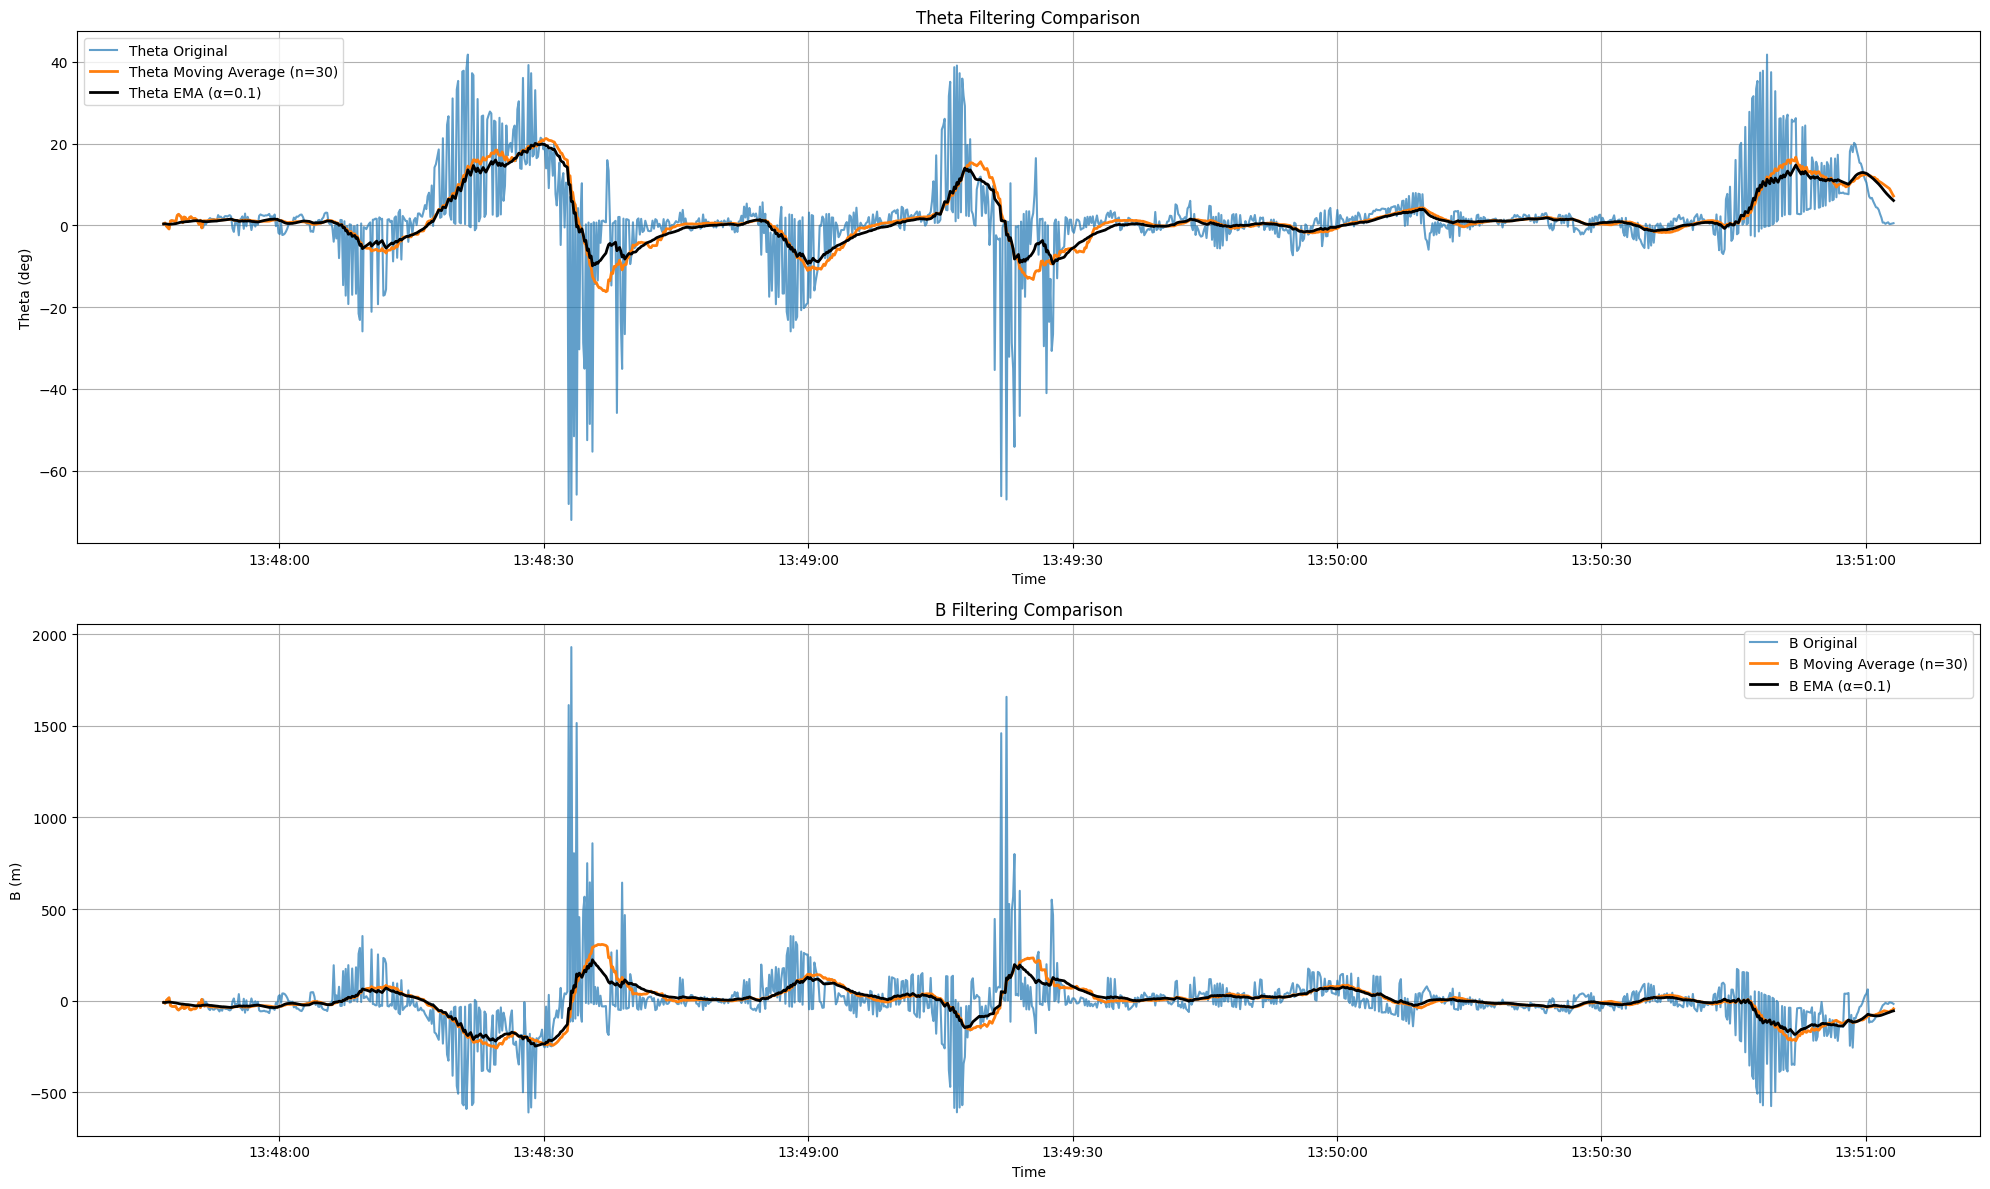

In [44]:
plt.figure(figsize=(20,12))

# Plot theta comparison
plt.subplot(2, 1, 1)
plt.plot(data.index, data['theta'], label='Theta Original', alpha=0.7)
plt.plot(data_realtime.index, data_realtime['theta_realtime_lpf'], label='Theta Moving Average (n=30)', linewidth=2)
plt.plot(data_realtime.index, data_realtime['theta_ema_lpf'], label='Theta EMA (α=0.1)', linewidth=2, color='black')
plt.xlabel('Time')
plt.ylabel('Theta (deg)')
plt.title('Theta Filtering Comparison')
plt.legend()
plt.grid()

# Plot b comparison
plt.subplot(2, 1, 2)
plt.plot(data.index, data['b'], label='B Original', alpha=0.7)
plt.plot(data_realtime.index, data_realtime['b_realtime_lpf'], label='B Moving Average (n=30)', linewidth=2)
plt.plot(data_realtime.index, data_realtime['b_ema_lpf'], label='B EMA (α=0.1)', linewidth=2, color='black')
plt.xlabel('Time')
plt.ylabel('B (m)')
plt.title('B Filtering Comparison')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()